Author: Sanjay Nayak

Affliation: Department of Computer Science & Engineering, Texas A&M University

Copyright 2023 Sanjay Nayak

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn import svm
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit

import xgboost as xgb

import plotly.express as px
import matplotlib.pyplot as plt

# Intent Prediction
1. Shopping
2. Recreation
3. Work & Travel
4. Studying
5. Chilling

# Load all data

In [2]:
clus_en_proc = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/cleaned_user_cat.csv")
clus_en_proc.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
clus_en_proc.head()

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime
0,user_11,13,5,0,WD,1,1,2,1,1,3
1,user_11,13,5,0,WD,1,1,2,1,1,3
2,user_11,13,5,0,WD,1,1,2,1,1,3
3,user_11,14,5,0,WD,1,1,2,1,1,3
4,user_11,14,5,0,WD,1,1,2,1,1,3


# Intent addition
Add intent column to the dataset by mapping the cluster to the 5 intents currently present.

Intent - 
1. Shopping
2. Recreation
3. Work & Travel
4. Studying
5. Chilling

Mapping Values	
*   H - Home (1) - 5
*   RT - Restaurant (2) - 2
*   U - University (3) - 4
*   O- Office (4) - 3
*   RC - Recreational (5) - 2
*   A - Airport (6) - 3
*   S - Supermarket (7) - 1

In [4]:
clus_en_proc["clusters"].unique()

array([1, 7, 5, 2, 4, 6, 3])

In [5]:
def map_intent(x):
    map_values = {1: 5, 2: 2, 3: 4, 4: 3, 5: 2, 6: 3, 7: 1}
    return map_values[x]

In [6]:
clus_en_proc["intent"] = clus_en_proc["clusters"].apply(lambda x: map_intent(x))

In [7]:
clus_en_proc.head()

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime,intent
0,user_11,13,5,0,WD,1,1,2,1,1,3,5
1,user_11,13,5,0,WD,1,1,2,1,1,3,5
2,user_11,13,5,0,WD,1,1,2,1,1,3,5
3,user_11,14,5,0,WD,1,1,2,1,1,3,5
4,user_11,14,5,0,WD,1,1,2,1,1,3,5


In [8]:
clus_df = clus_en_proc.drop(columns=["labels", "daytime"])
clus_df["daytype"] = clus_df["day_type"].apply(lambda x: 0 if x == "WD" else 1)
clus_df["users"] = clus_df["user"].apply(lambda x: int(x.split("_")[1]))
clus_df.drop(columns=["day_type", "user"], inplace=True)
clus_df.rename(columns={"users": "user"}, inplace=True)

In [9]:
clus_df.sample(5)

,hour,weekday,charging_type,bluetooth,wifi,charging_status,clusters,intent,daytype,user
11834,16,0,2,3,2,2,1,5,0,13
48310,4,6,1,3,2,1,3,4,1,14
47303,9,1,2,3,1,2,3,4,0,14
86375,13,4,1,3,2,1,3,4,0,5
89829,22,4,1,3,1,1,1,5,0,9


In [10]:
clus_df.shape

(90641, 10)

In [11]:
users_unique = clus_df["user"].unique()

In [12]:
clus_df.corr()

,hour,weekday,charging_type,bluetooth,wifi,charging_status,clusters,intent,daytype,user
hour,1.000000,-0.039252,-0.115601,-0.030892,-0.136321,-0.116338,0.111455,-0.114922,-0.010118,-0.005881
weekday,-0.039252,1.000000,0.027479,0.058577,0.003251,0.022307,-0.015569,-0.001889,0.589175,0.003653
charging_type,-0.115601,0.027479,1.000000,0.010933,0.118745,0.990684,-0.098274,0.107494,0.022358,0.002816
bluetooth,-0.030892,0.058577,0.010933,1.000000,-0.006553,0.009935,0.109355,-0.089409,0.027210,-0.194290
wifi,-0.136321,0.003251,0.118745,-0.006553,1.000000,0.121343,-0.012892,0.057819,0.019374,-0.020118
charging_status,-0.116338,0.022307,0.990684,0.009935,0.121343,1.000000,-0.095793,0.105887,0.015932,0.004802
clusters,0.111455,-0.015569,-0.098274,0.109355,-0.012892,-0.095793,1.000000,-0.954630,-0.070508,-0.090568
intent,-0.114922,-0.001889,0.107494,-0.089409,0.057819,0.105887,-0.954630,1.000000,0.061598,0.038627
daytype,-0.010118,0.589175,0.022358,0.027210,0.019374,0.015932,-0.070508,0.061598,1.000000,0.080825
user,-0.005881,0.003653,0.002816,-0.194290,-0.020118,0.004802,-0.090568,0.038627,0.080825,1.000000


### Correlation matrix of the features - hour, weekday, charging_type, bluetooth, wifi, charging_status, clusters, daytype

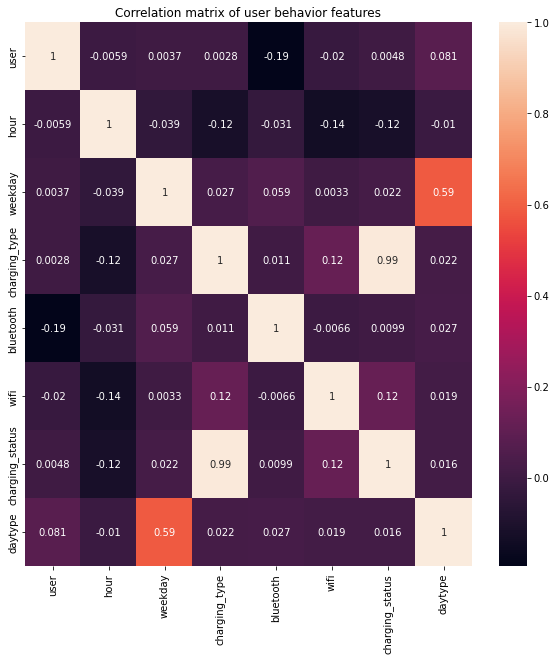

In [9]:
fig = plt.figure(figsize=(10, 10))
seaborn.heatmap(clus_df[["user", "hour", "weekday", "charging_type", "bluetooth", "wifi", "charging_status", "daytype"]].corr(), annot=True)
plt.title("Correlation matrix of user behavior features")
plt.show()

In [13]:
def change_user_to_int(df):
    df["users"] = df["user"].apply(lambda x: int(x.split("_")[1]))
    df.drop(columns=["user"], inplace=True)
    df.rename(columns={"users": "user"}, inplace=True)
    return df

In [14]:
loc_hr_df = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/location_hour_proba.csv")
loc_hr_df.drop(columns=["Unnamed: 0"], inplace=True)
print(f"Shape of location hour df probability: {loc_hr_df.shape}")

usr_loc_hr_df = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_hour_proba.csv")
usr_loc_hr_df.drop(columns=["Unnamed: 0"], inplace=True)
usr_loc_hr_df = change_user_to_int(usr_loc_hr_df)
print(f"Shape of location hour df probability: {usr_loc_hr_df.shape}")

usr_loc_dy_df = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_day_proba.csv")
usr_loc_dy_df.drop(columns=["Unnamed: 0"], inplace=True)
usr_loc_dy_df = change_user_to_int(usr_loc_dy_df)
print(f"Shape of location hour df probability: {usr_loc_dy_df.shape}")

usr_loc_dyt_df = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_daytype_proba.csv")
usr_loc_dyt_df.drop(columns=["Unnamed: 0"], inplace=True)
usr_loc_dyt_df = change_user_to_int(usr_loc_dyt_df)
print(f"Shape of location hour df probability: {usr_loc_dyt_df.shape}")

Shape of location hour df probability: (24, 7)
Shape of location hour df probability: (216, 9)
Shape of location hour df probability: (63, 9)
Shape of location hour df probability: (18, 9)


In [15]:
loc_hr_df.head()

,H,RT,U,O,RC,A,S
0,0.756327,0.004039,0.200054,0.000808,0.019655,0.00727,0.011847
1,0.734975,0.000000,0.235708,0.000000,0.014072,0.00000,0.015245
2,0.746606,0.000000,0.217195,0.000000,0.013952,0.00000,0.022247
3,0.730549,0.000000,0.226374,0.000000,0.014505,0.00000,0.028571
4,0.727863,0.000000,0.239685,0.000000,0.010199,0.00000,0.022253


In [16]:
usr_loc_hr_df.head()

,hour,H,RT,U,O,RC,A,S,user
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11


In [17]:
usr_loc_dy_df.head()

,weekday,H,RT,U,O,RC,A,S,user
0,0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,11
1,1,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,11
2,2,0.753883,0.0,0.0,0.0,0.235364,0.0,0.010753,11
3,3,0.797063,0.0,0.0,0.0,0.201602,0.0,0.001335,11
4,4,0.673913,0.0,0.0,0.0,0.233954,0.0,0.092133,11


In [18]:
usr_loc_dyt_df.head()

,daytype,H,RT,U,O,RC,A,S,user
0,0,0.839636,0.000000,0.000000,0.000000,0.133987,0.000000,0.026377,11
1,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11
2,0,0.897203,0.010280,0.027891,0.003905,0.031795,0.015499,0.013427,13
3,1,0.824219,0.025521,0.014063,0.007552,0.121615,0.007031,0.000000,13
4,0,0.340746,0.000425,0.647070,0.000425,0.003636,0.000000,0.007697,14


# Division of data into X and y

* Divide the dataset into inputs (X) and labels (y)

#### Get the start and end index of each user data

In [19]:
user_index = dict()
for usr in users_unique:
    tmp_x = clus_df[clus_df["user"]==usr]
    indxs = tmp_x.index
    user_index[usr] = {"start": indxs[0], "end": indxs[-1]}
print("Done")

Done


In [20]:
user_index

{11: {'start': 0, 'end': 4783},
 13: {'start': 4784, 'end': 33721},
 14: {'start': 33722, 'end': 63133},
 18: {'start': 63134, 'end': 72818},
 21: {'start': 72819, 'end': 78383},
 23: {'start': 78384, 'end': 81537},
 5: {'start': 81538, 'end': 86802},
 8: {'start': 86803, 'end': 88696},
 9: {'start': 88697, 'end': 90640}}

#### Labels of the dataset without onehot encoding

In [21]:
labels = clus_df["clusters"]
intent = clus_df["intent"]
features_df = clus_df[["user", "hour", "weekday", "charging_type", "bluetooth", "wifi", "charging_status", "daytype"]]

#### One hot encoding of input data

In [22]:
clus_df.head(3)

,hour,weekday,charging_type,bluetooth,wifi,charging_status,clusters,intent,daytype,user
0,13,0,1,1,2,1,1,5,0,11
1,13,0,1,1,2,1,1,5,0,11
2,13,0,1,1,2,1,1,5,0,11


#### Use the `user` column for model trainings

In [23]:
# onehot_df = pd.get_dummies(data=clust_en_df, columns=["user", "daytime", "charging_type", "wifi", "bluetooth", "charging_status"])
# onehot_df_all = pd.get_dummies(data=clust_en_df, columns=["user", "daytime", "charging_type", "wifi", "bluetooth", "charging_status", "clusters"])

onehot_features = pd.get_dummies(data=features_df, columns=features_df.columns)

In [24]:
onehot_features.head()

,user_5,user_8,user_9,user_11,user_13,user_14,user_18,user_21,user_23,hour_0,...,bluetooth_2,bluetooth_3,bluetooth_4,bluetooth_5,wifi_1,wifi_2,charging_status_1,charging_status_2,daytype_0,daytype_1
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [25]:
onehot_features.columns

Index(['user_5', 'user_8', 'user_9', 'user_11', 'user_13', 'user_14',
       'user_18', 'user_21', 'user_23', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'charging_type_1',
       'charging_type_2', 'charging_type_3', 'bluetooth_1', 'bluetooth_2',
       'bluetooth_3', 'bluetooth_4', 'bluetooth_5', 'wifi_1', 'wifi_2',
       'charging_status_1', 'charging_status_2', 'daytype_0', 'daytype_1'],
      dtype='object')

### Save the one hot features df and the labels df

In [27]:
labels.to_csv("/content/drive/MyDrive/thesis/preprocessing/training_files/labels.csv")
intent.to_csv("/content/drive/MyDrive/thesis/preprocessing/training_files/intents.csv")
onehot_features.to_csv("/content/drive/MyDrive/thesis/preprocessing/training_files/onehot_features.csv")

#### Remove `user` column from the dataframe and then train the models - not used

In [ ]:
# clust_en_df = clust_en_df.drop(columns=["user"])

In [ ]:
# onehot_df = pd.get_dummies(data=clust_en_df, columns=["daytime", "charging_type", "wifi", "bluetooth", "charging_status"])
# onehot_df_all = pd.get_dummies(data=clust_en_df, columns=["daytime", "charging_type", "wifi", "bluetooth", "charging_status", "clusters"])

In [ ]:
# onehot_df.iloc[0]

In [ ]:
# onehot_df_all.iloc[0]

In [ ]:
# # columns to use. Use all columns except the cluster column
# X = onehot_df.drop(columns=["clusters"]).to_numpy()

In [ ]:
# X[0]

In [ ]:
# labels[0]

In [ ]:
# y = labels
# y_onehot = onehot_df_all[["clusters_1", "clusters_2", "clusters_3", "clusters_4", "clusters_5", "clusters_6", "clusters_7"]].to_numpy()

In [ ]:
# y_onehot.shape

#### Create numpy array of X and y

In [26]:
X_main = onehot_features.to_numpy()
X_main.shape

(90641, 54)

Use `labels` for location prediction

Use `intent` for intent prediction

In [27]:
# y_main = labels.to_numpy()
y_main = intent.to_numpy()
y_main.shape

(90641,)

In [28]:
# Take training and testing data from each user
def divide_train_test_user(X, y, ratio=0.7):
    X_train, X_test, y_train, y_test = None, None, None, None
    for us, idxs in user_index.items():
        divide = int(ratio*(idxs["end"] - idxs["start"]))

        if X_train is None:
            X_train = X[idxs["start"]: divide + idxs["start"]]
        elif X_train is not None:
            X_train = np.concatenate((X_train, X[idxs["start"]: divide + idxs["start"]]), axis=0)

        if y_train is None:
            y_train = y[idxs["start"]: divide + idxs["start"]]
        elif y_train is not None:
            y_train = np.concatenate((y_train, y[idxs["start"]: divide + idxs["start"]]), axis=0)
        
        if X_test is None:
            X_test = X[divide + idxs["start"]: idxs["end"] + 1]
        elif X_test is not None:
            X_test = np.concatenate((X_test, X[divide + idxs["start"]: idxs["end"]]), axis=0)
        
        if y_test is None:
            y_test = y[divide + idxs["start"]: idxs["end"] + 1]
        elif y_test is not None:
            y_test = np.concatenate((y_test, y[divide + idxs["start"]: idxs["end"]]), axis=0)
        
        # print(us, idxs["start"], divide + idxs["start"], idxs["end"] + 1, idxs["end"] - idxs["start"] + 1)
    
    return X_train, X_test, y_train, y_test

In [29]:
def divide_train_test(X, y, ratio=0.8):
    divide = int(ratio*X.shape[0])
    X_train, X_test = X[:divide], X[divide:]
    y_train, y_test = y[:divide], y[divide:]

    return X_train, X_test, y_train, y_test

#### Prediction function

In [30]:
def get_accuracy(y_pred, y):
    correct_pred = 0
    correct_pred += (y_pred == y).sum()/y.shape[0]

    return correct_pred

# Random Forest Classifier

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.3, random_state=100)
X_train, y_train = shuffle(X_train, y_train)

rfc = RandomForestClassifier(random_state=40)
X_train, y_train = shuffle(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [34]:
# predict
predict_rfc = rfc.predict(X_test)

In [35]:
accuracy_rfc = get_accuracy(predict_rfc, y_test)
print(f"Random Forest Classifier accuracy: {accuracy_rfc}")

Random Forest Classifier accuracy: 0.9001213547604163


In [36]:
set(predict_rfc)

{1, 2, 3, 4, 5}

# XGBoost Classifier

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.3, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

In [38]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob', random_state=42)

In [39]:
predict_xgb = xgb_model.predict(X_test)
accuracy_xgb = get_accuracy(predict_xgb, y_test)
print(f"XGBoost Classifier accuracy: {accuracy_xgb}")

XGBoost Classifier accuracy: 0.8158349575258339


In [40]:
set(predict_xgb)

{1, 2, 3, 4, 5}

# SVM

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.3, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

In [42]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC()

In [43]:
predict_svm = svm_model.predict(X_test)
accuracy_svm = get_accuracy(predict_svm, y_test)
print(f"SVM Classifier accuracy: {accuracy_svm}")

SVM Classifier accuracy: 0.8939065200603097


In [44]:
set(predict_svm)

{1, 2, 3, 4, 5}

# LSTM - Pytorch

In [ ]:
EPOCHS = 10
# No of features
INPUT_SIZE = 54
# No of features in hidden state
HIDDEN_SIZE = 75
# No of stacked LSTM layers
NUM_LAYERS = 1
# No of output classes
NUM_CLASSES = 7
LEARNING_RATE = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
y_onehot = pd.get_dummies(labels)
y_onehot = y_onehot.to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
# X_train, y_train = shuffle(X_train, y_train)
X_train, X_test, y_train, y_test = divide_train_test(X_main, y_onehot, ratio=0.7)

In [ ]:
# y_train_tensor = torch.Tensor(y_train - 1).type(torch.LongTensor)
# y_test_sensor = torch.Tensor(y_test - 1).type(torch.LongTensor)

In [ ]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

X_test_tensor = torch.Tensor(X_test)
y_test_sensor = torch.Tensor(y_test)

# Reshaping the tensor to 3-D for X (rows, 1, features) and 2-D for y
X_train_tensor = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
y_train_tensor = torch.reshape(y_train_tensor, (y_train_tensor.shape[0], y_train_tensor.shape[1]))

X_test_tensor = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
y_test_tensor = torch.reshape(y_test_sensor, (y_test_sensor.shape[0], y_test_sensor.shape[1]))

In [ ]:
print(f"Training Shape: X: {X_train_tensor.shape}, y: {y_train_tensor.shape}")
print(f"Testing Shape: X: {X_test_tensor.shape}, y: {y_test_sensor.shape}")

Training Shape: X: torch.Size([63448, 1, 54]), y: torch.Size([63448, 7])
Testing Shape: X: torch.Size([27193, 1, 54]), y: torch.Size([27193, 7])


In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_Model, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=-1)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.logSoftmax(out)

        return out

In [ ]:
model_lstm = LSTM_Model(NUM_CLASSES, INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, X_train_tensor.shape[1]).to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lstm.parameters(), lr=LEARNING_RATE)

In [ ]:
print(model_lstm)

LSTM_Model(
  (lstm): LSTM(54, 75, batch_first=True)
  (fc1): Linear(in_features=75, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (logSoftmax): LogSoftmax(dim=-1)
  (relu): ReLU()
)


In [ ]:
for epoch in range(100):
    if epoch % 500 == 0:
        LEARNING_RATE = LEARNING_RATE / 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE

    optimizer.zero_grad()
    output = model_lstm(X_train_tensor.to(DEVICE))

    loss = criterion(output, y_train_tensor.to(DEVICE))
    loss.backward()

    optimizer.step()

    if epoch % 20 == 0 or epoch == 100 - 1:
        print(f'{datetime.datetime.now().time()} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {loss}')

11:08:05.523803 --- Epoch: 0	Train loss: 1.9486267566680908
11:08:23.207905 --- Epoch: 20	Train loss: 1.6629637479782104
11:08:38.338496 --- Epoch: 40	Train loss: 0.9485217332839966
11:08:53.893474 --- Epoch: 60	Train loss: 0.8430185914039612
11:09:10.730881 --- Epoch: 80	Train loss: 0.6970074772834778
11:09:26.432355 --- Epoch: 99	Train loss: 0.5693208575248718


In [ ]:
valid_out = model_lstm(X_test_tensor.to(DEVICE))

In [ ]:
accuracy_lstm = get_accuracy(valid_out.argmax(1).cpu().numpy(), y_test.argmax(1))
print(f"LSTM accuracy: {accuracy_lstm}")

LSTM accuracy: 0.46328099143161844


In [ ]:
set(valid_out.argmax(1).cpu().numpy() + 1)

{1, 3}

# LSTM (Keras)

In [31]:
from numpy import array

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import LSTM, Dense, Flatten, Dropout, TimeDistributed, ConvLSTM2D, Layer, Activation, Add, Reshape

In [32]:
def timeseries_split_sequence(sequence, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return array(X_seq), array(y_seq)

Use `labels` for location prediction

Use `intent` for intent prediction

In [33]:
# y_onehot = pd.get_dummies(labels)
y_onehot = pd.get_dummies(intent)
y_onehot = y_onehot.to_numpy()

In [34]:
y_onehot.shape

(90641, 5)

Add in conference paper

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 80, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.4))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history_lstm = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [50]:
# save the history of lstm model
history_lstm_df = pd.DataFrame.from_dict(history_lstm.history)
epoch_list = [i for i in range(1,81)]
history_lstm_df["epoch"] = epoch_list
history_lstm_df.to_csv("/content/drive/MyDrive/thesis/results/intent_hist_lstm.csv")
print("Saved")

Saved


In [51]:
history_lstm_df["accuracy"].max()

0.8969864845275879

In [ ]:
print(f"LSTM (Keras) 3 LSTM layers accuracy: {accuracy}")

LSTM (Keras) 3 LSTM layers accuracy: 0.8807413578033447


Not required to be included in the conference paper

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"LSTM (Keras) accuracy: {accuracy}")

LSTM (Keras) accuracy: 0.8949729800224304


## CNN-LSTM model

Include this in conference

In [52]:
# CNN + LSTM 3 layers
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 80, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history_cnn_lstm = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [53]:
# save the history of cnn lstm model
history_cnn_lstm_df = pd.DataFrame.from_dict(history_cnn_lstm.history)
epoch_list = [i for i in range(1,81)]
history_cnn_lstm_df["epoch"] = epoch_list
history_cnn_lstm_df.to_csv("/content/drive/MyDrive/thesis/results/intent_hist_cnn_lstm.csv")
print("Saved")

Saved


In [54]:
history_cnn_lstm_df.head()

,loss,accuracy,epoch
0,0.550360,0.783744,1
1,0.334187,0.861997,2
2,0.292630,0.876040,3
3,0.274007,0.880075,4
4,0.263225,0.883669,5


In [55]:
history_cnn_lstm_df["accuracy"].max()

0.9015414118766785

In [ ]:
print(f"CNN-LSTM (Keras) 3 LSTM layer accuracy: {accuracy}")

CNN-LSTM (Keras) 3 LSTM layer accuracy: 0.8962600827217102


Don't include this in conference

In [ ]:
# CNN only
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"CNN-LSTM (Keras) accuracy: {accuracy}")

CNN-LSTM (Keras) accuracy: 0.8940168619155884


Don't include in conference

In [ ]:
# CNN + LSTM
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"CNN-LSTM Time distributed (Keras) accuracy: {accuracy}")

CNN-LSTM Time distributed (Keras) accuracy: 0.8957819938659668


Don't include in conference

In [ ]:
# CNN + LSTM
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 25, 128
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"CNN-LSTM Time distributed (Keras), batch size 128, accuracy: {accuracy}")

CNN-LSTM Time distributed (Keras), batch size 128, accuracy: 0.896149754524231


Don't include in conference

In [ ]:
# CNN + LSTM
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 25, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"CNN-LSTM Time distributed (Keras), batch size 32, accuracy: {accuracy}")

CNN-LSTM Time distributed (Keras), batch size 32, accuracy: 0.8896039128303528


# Conv-LSTM model

Don't include in conference

In [ ]:
# Convolutional LSTM
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [ ]:
print(f"Conv-LSTM (Keras) accuracy: {accuracy}")

Conv-LSTM (Keras) accuracy: 0.8890891075134277


Include in conference

In [56]:
# Convolutional LSTM 3 layers
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 80, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='relu', return_sequences=True, input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.4))
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history_convlstm = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [57]:
# save the history of conv lstm model
history_convlstm_df = pd.DataFrame.from_dict(history_convlstm.history)
epoch_list = [i for i in range(1,81)]
history_convlstm_df["epoch"] = epoch_list
history_convlstm_df.to_csv("/content/drive/MyDrive/thesis/results/intent_hist_convlstm.csv")
print("Saved")

Saved


In [58]:
history_convlstm_df["accuracy"].max()

0.8965294361114502

In [ ]:
print(f"Conv-LSTM (Keras) accuracy: {accuracy}")

Conv-LSTM (Keras) accuracy: 0.8907071948051453


# Resnet-LSTM Model

Include in conference. Main part to show.

In [35]:
from keras.layers.convolutional.conv2d_transpose import Conv2D
class ResidualNetwork(Layer):
    def __init__(self, in_channels, kernel, **kwargs):
        super(ResidualNetwork, self).__init__(**kwargs)
        self.in_channels = in_channels
        self.kernel = kernel
        self.conv2d = Conv2D(self.in_channels, self.kernel, padding="same")
        self.relu = Activation("relu")
        self.fl = Activation("linear", trainable=False)

    def call(self, x):
        fl = self.fl(x)
        y = self.conv2d(fl)
        y = self.relu(y)
        y = self.conv2d(y)
        residue = Add()([y, fl])
        y = self.relu(residue)
        return y
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_onehot, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
verbose, epochs, batch_size = 0, 80, 128
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 1, 1
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding="same", input_shape=(n_steps, 1, n_length, n_features))))
model.add(TimeDistributed(ResidualNetwork(128, (1,1))))
# model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding="same")))
model.add(TimeDistributed(ResidualNetwork(128, (1,1))))
# model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding="same")))
model.add(TimeDistributed(ResidualNetwork(128, (1,1))))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
# model.add(Reshape((1,64)))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

opt = Adam(epsilon=1e-7)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit network
X_train = X_train.astype("float")
history_resnet_lstm = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

In [37]:
# save the history of resnet lstm model
history_resnet_lstm_df = pd.DataFrame.from_dict(history_resnet_lstm.history)
epoch_list = [i for i in range(1,81)]
history_resnet_lstm_df["epoch"] = epoch_list
history_resnet_lstm_df.to_csv("/content/drive/MyDrive/thesis/results/intent_hist_resnet_lstm.csv")
print("Saved")

Saved


In [38]:
history_resnet_lstm_df.head()

,loss,accuracy,epoch
0,1.031377,0.574108,1
1,0.893543,0.611871,2
2,0.443949,0.828679,3
3,0.341180,0.857553,4
4,0.304375,0.869862,5


In [39]:
history_resnet_lstm_df["accuracy"].max()

0.9012262225151062

In [40]:
history_resnet_lstm_df["accuracy"].idxmax()

76

In [41]:
history_resnet_lstm_df.iloc[76:]

,loss,accuracy,epoch
76,0.205686,0.901226,77
77,0.203972,0.900990,78
78,0.205821,0.900943,79
79,0.203132,0.899745,80


In [ ]:
print(f"Resnet-LSTM (Keras time distributed epsilon 1e-7) LSTM 3 layers accuracy test: {accuracy}")

Resnet-LSTM (Keras time distributed epsilon 1e-7) LSTM 3 layers accuracy test: 0.8977310061454773


In [ ]:
print(f"Resnet-LSTM (Keras time distributed epsilon 1e-7) LSTM 3 layers accuracy: {accuracy}")

Resnet-LSTM (Keras time distributed epsilon 1e-7) LSTM 3 layers accuracy: 0.8977310061454773


In [ ]:
print(f"Resnet-LSTM (Keras time distributed epsilon 1e-4) accuracy: {accuracy}")

Resnet-LSTM (Keras time distributed epsilon 1e-4) accuracy: 0.8942007422447205


In [ ]:
print(f"Resnet-LSTM (Keras time distributed, batch 128) accuracy: {accuracy}")

Resnet-LSTM (Keras time distributed, batch 128) accuracy: 0.8962600827217102


In [ ]:
print(f"Resnet-LSTM (Keras time distributed) accuracy: {accuracy}")

Resnet-LSTM (Keras time distributed) accuracy: 0.8965542316436768


In [ ]:
print(f"Resnet-LSTM (Keras) accuracy: {accuracy}")

Resnet-LSTM (Keras) accuracy: 0.8956716656684875


# DL algorithm accuracy and loss plots

In [7]:
# read the csv containing accuracy and loss of each DL algorithms used
history_resnet_lstm_df = pd.read_csv("/content/drive/MyDrive/thesis/results/hist_resnet_lstm.csv", index_col=0)
history_convlstm_df = pd.read_csv("/content/drive/MyDrive/thesis/results/hist_convlstm.csv", index_col=0)
history_cnn_lstm_df = pd.read_csv("/content/drive/MyDrive/thesis/results/hist_cnn_lstm.csv", index_col=0)
history_lstm_df = pd.read_csv("/content/drive/MyDrive/thesis/results/hist_lstm.csv", index_col=0)

In [17]:
history_lstm_df.head()

,loss,accuracy
0,0.666363,0.746958
1,0.490006,0.803745
2,0.445497,0.819080
3,0.410530,0.832666
4,0.383293,0.843982


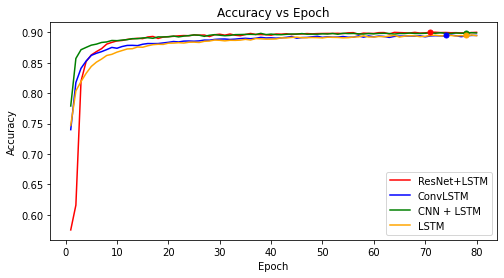

In [38]:
fig = plt.figure(figsize=(8,4))
plt.title("Accuracy vs Epoch")
# history_resnet_lstm_df.plot.line(x="epoch", y="accuracy")
plt.plot(list(history_resnet_lstm_df["epoch"]), list(history_resnet_lstm_df["accuracy"]), color="red", label="ResNet+LSTM")
plt.plot(list(history_convlstm_df["epoch"]), list(history_convlstm_df["accuracy"]), color="blue", label="ConvLSTM")
plt.plot(list(history_cnn_lstm_df["epoch"]), list(history_cnn_lstm_df["accuracy"]), color="green", label="CNN + LSTM")
plt.plot(list(history_cnn_lstm_df["epoch"]), list(history_lstm_df["accuracy"]), color="orange", label="LSTM")

# Points having epoch with highest accuracy

acc_idx_res = history_resnet_lstm_df["accuracy"].idxmax()
plt.plot(acc_idx_res, history_resnet_lstm_df["accuracy"].iloc[acc_idx_res], marker=".", color="red", markersize=10)

acc_idx_conv = history_convlstm_df["accuracy"].idxmax()
plt.plot(acc_idx_conv, history_convlstm_df["accuracy"].iloc[acc_idx_conv], marker=".", color="blue", markersize=10)

acc_idx_cnn = history_cnn_lstm_df["accuracy"].idxmax()
plt.plot(acc_idx_cnn, history_cnn_lstm_df["accuracy"].iloc[acc_idx_cnn], marker=".", color="green", markersize=10)

acc_idx_lstm = history_lstm_df["accuracy"].idxmax()
plt.plot(acc_idx_lstm, history_lstm_df["accuracy"].iloc[acc_idx_lstm], marker=".", color="orange", markersize=10)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
print(f"ResNet + LSTM best accuracy: {round(history_resnet_lstm_df['accuracy'].iloc[acc_idx_res]*100, 3)}, Epoch: {acc_idx_res}")
print(f"Convolutional LSTM best accuracy: {round(history_convlstm_df['accuracy'].iloc[acc_idx_conv]*100, 3)}, Epoch: {acc_idx_conv}")
print(f"CNN + LSTM best accuracy: {round(history_cnn_lstm_df['accuracy'].iloc[acc_idx_cnn]*100, 3)}, Epoch: {acc_idx_cnn}")
print(f"LSTM best accuracy: {round(history_lstm_df['accuracy'].iloc[acc_idx_lstm]*100, 3)}, Epoch: {acc_idx_lstm}")

ResNet + LSTM best accuracy: 90.025, Epoch: 71
Convolutional LSTM best accuracy: 89.563, Epoch: 74
CNN + LSTM best accuracy: 89.951, Epoch: 78
LSTM best accuracy: 89.574, Epoch: 78


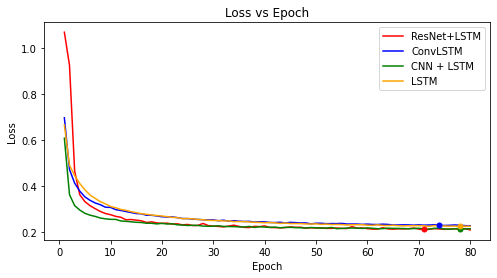

In [39]:
fig = plt.figure(figsize=(8,4))
plt.title("Loss vs Epoch")
# history_resnet_lstm_df.plot.line(x="epoch", y="accuracy")
plt.plot(list(history_resnet_lstm_df["epoch"]), list(history_resnet_lstm_df["loss"]), color="red", label="ResNet+LSTM")
plt.plot(list(history_convlstm_df["epoch"]), list(history_convlstm_df["loss"]), color="blue", label="ConvLSTM")
plt.plot(list(history_cnn_lstm_df["epoch"]), list(history_cnn_lstm_df["loss"]), color="green", label="CNN + LSTM")
plt.plot(list(history_cnn_lstm_df["epoch"]), list(history_lstm_df["loss"]), color="orange", label="LSTM")

# The points are taken from the epoch with highest accuracy

# acc_idx = history_resnet_lstm_df["loss"].idxmin()
plt.plot(acc_idx_res, history_resnet_lstm_df["loss"].iloc[acc_idx_res], marker=".", color="red", markersize=10)

# acc_idx = history_convlstm_df["loss"].idxmin()
plt.plot(acc_idx_conv, history_convlstm_df["loss"].iloc[acc_idx_conv], marker=".", color="blue", markersize=10)

# acc_idx = history_cnn_lstm_df["loss"].idxmin()
plt.plot(acc_idx_cnn, history_cnn_lstm_df["loss"].iloc[acc_idx_cnn], marker=".", color="green", markersize=10)

# acc_idx = history_lstm_df["loss"].idxmin()
plt.plot(acc_idx_lstm, history_lstm_df["loss"].iloc[acc_idx_lstm], marker=".", color="orange", markersize=10)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Bayesian Model, HMM

1. Use 80% of data for each user as training and 20% as test.
2. Remove the user data from training data, train the model, and check the accuracy - accuracy dropped. With user attributes, the accuracy was more.

1. Random Forest - done
2. XGBoost Classifier - done
3. CNN - Not required
4. LSTM - done
5. ConvNet + LSTM - done
6. Hidden Markov Model
7. Graph Neural Network?
8. SVM - done
9. CNN + LSTM - done

1. Use 24 hour instead of the 6 time types
2. Merge the less no of location types into 1 or other location types
3. entering and exiting a location
4. Stochastic modeling, pyro - important
5. TDNN
6. 70% train, 20% test, 10% valid
7. 24 HMM for each hour

# Training with 80% data from each user - Not used


In [ ]:
# rfc_usr = RandomForestClassifier(random_state=40)
# X_usr, y_usr = shuffle(X, y)
# X_train_usr, X_test_usr, y_train_usr, y_test_usr = divide_train_test_user(X_usr, y_usr, 0.865)
# # X_train_usr, y_train_usr = shuffle(X_train_usr, y_train_usr)
# rfc_usr.fit(X_train_usr, y_train_usr)

RandomForestClassifier(random_state=40)

In [ ]:
# # predict
# predict_rfc_usr = rfc_usr.predict(X_test_usr)

In [ ]:
# accuracy_rfc_usr = get_accuracy(predict_rfc_usr, y_test_usr)
# print(f"Random Forest Classifier accuracy: {accuracy_rfc_usr}")

Random Forest Classifier accuracy: 0.7172864644732612


In [ ]:
# set(predict_rfc_usr)

{1, 3, 5, 6, 7}